# Pipeline BaseLine: YOLO -> Bounding Boxes -> Translation (Pinhole Camera Model) -> Resnet -> 6D Pose 


> Approccio base citato dalla prof su Discord

## 1. Import e Setup

In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import yaml
import pandas as pd
import random
from PIL import Image
from scipy.spatial.transform import Rotation

# Importa il config e utilities
sys.path.insert(0, str(Path.cwd().parent))  # Aggiungi parent al path
from config import Config

# ✅ Import BASELINE model e Pinhole
from models.pose_estimator_baseline import PoseEstimatorBaseline
from models.yolo_detector import YOLODetector
from utils.pinhole import load_camera_intrinsics, compute_translation_pinhole
from utils.transforms import crop_image_from_bbox, get_pose_transforms
from utils.losses import PoseLossBaseline

# Usa PROJECT_ROOT dal config
project_root = Config.PROJECT_ROOT
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Configura matplotlib per notebook
%matplotlib inline

print(f"✅ Setup completato (BASELINE MODEL)")
print(f"📂 Project root: {project_root}")
print(f"🎯 Dataset: LineMOD")
print(f"🖥️  Device: {Config.DEVICE}")
print(f"📊 Image size: {Config.POSE_IMAGE_SIZE}x{Config.POSE_IMAGE_SIZE}")
print(f"\n🔧 Baseline Configuration:")
print(f"   Translation: Pinhole Camera Model (geometric)")
print(f"   Rotation: ResNet50 → Quaternion (learned)")
print(f"   Depth: Required for Pinhole computation")

Cache Strategy: partial
Numworkers set to 0
Numworkers set to 0
✅ Setup completato (BASELINE MODEL)
📂 Project root: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation
🎯 Dataset: LineMOD
🖥️  Device: mps
📊 Image size: 224x224

🔧 Baseline Configuration:
   Translation: Pinhole Camera Model (geometric)
   Rotation: ResNet50 → Quaternion (learned)
   Depth: Required for Pinhole computation


## 2. Carica Modelli Pre-Trained

In [ ]:
# ====== CARICAMENTO MODELLI ======

# 1. YOLO Fine-tuned per detection
print("=" * 60)
print("📦 CARICAMENTO YOLO DETECTOR")
print("=" * 60)

YOLO_MODEL = f'yolo_train{Config.YOLO_EPOCHS}'
yolo_weights = Config.CHECKPOINT_DIR / 'yolo' / YOLO_MODEL / 'weights' / 'best.pt'

if yolo_weights.exists():
    print(f"✅ Carico YOLO: {yolo_weights.relative_to(project_root)}\n")
    yolo_detector = YOLODetector(
        model_name=str(yolo_weights),
        num_classes=Config.NUM_CLASSES
    )
    print(f"✅ YOLO caricato con successo!\n")
else:
    print(f"❌ YOLO weights non trovati: {yolo_weights}")
    print(f"   Allena prima YOLO (vedi test3_yolo2_finetuning.ipynb)\n")
    yolo_detector = None

# 2. PoseEstimatorBaseline (ResNet50) per rotation
print("=" * 60)
print("📦 CARICAMENTO POSE ESTIMATOR BASELINE (ResNet50 - Rotation Only)")
print("=" * 60)

# TODO: Al momento usa modello non trained, dopo training baseline aggiorna qui
BASELINE_MODEL = f"baseline_train{Config.POSE_EPOCHS}"  # Da creare dopo training
checkpoint_dir = project_root / 'checkpoints' / 'pose' / BASELINE_MODEL
checkpoint_path = checkpoint_dir / 'weights' / 'best.pt'

# Inizializza modello baseline
model_baseline = PoseEstimatorBaseline(
    pretrained=True,
    dropout=Config.POSE_DROPOUT,
    freeze_backbone=False
).to(Config.DEVICE)

# Carica weights se esistono
if checkpoint_path.exists():
    print(f"\n✅ Carico checkpoint: {checkpoint_path.relative_to(project_root)}")
    checkpoint = torch.load(checkpoint_path, map_location=Config.DEVICE)
    model_baseline.load_state_dict(checkpoint['model_state_dict'])
    model_baseline.eval()
    
    print(f"📊 Checkpoint info:")
    print(f"   Epoch: {checkpoint.get('epoch', 0) + 1}")
    print(f"   Loss (rotation): {checkpoint.get('loss', 0):.4f}")
    print(f"\n✅ PoseEstimatorBaseline caricato e in modalità eval!")
else:
    print(f"\n⚠️  Checkpoint non trovato: {checkpoint_path}")
    print(f"   Usando modello con solo pretrained ImageNet weights")
    print(f"   Per risultati ottimali, allena prima il baseline model")
    print(f"   (vedi train_pose_baseline.py)\n")
    model_baseline.eval()

# Riepilogo modelli caricati
print("\n" + "=" * 60)
print("📋 RIEPILOGO MODELLI CARICATI")
print("=" * 60)
print(f"YOLO Detector:          {'✅ Caricato' if yolo_detector is not None else '❌ Non disponibile'}")
print(f"PoseEstimatorBaseline:  ✅ Caricato")
print(f"\n💡 Pipeline Baseline:")
print(f"   YOLO → Bbox → Pinhole (translation) → ResNet (rotation) → 6D Pose")
if yolo_detector is not None:
    print(f"\n🚀 Tutto pronto per la pipeline baseline!")
else:
    print(f"\n⚠️  YOLO mancante. Verifica i checkpoint.")
print("=" * 60)

📦 CARICAMENTO YOLO DETECTOR
✅ Carico YOLO: checkpoints/yolo/yolo_train20/weights/best.pt

✅ Loading custom weights from: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/yolo/yolo_train20/weights/best.pt
✅ YOLO caricato con successo!

📦 CARICAMENTO POSE ESTIMATOR BASELINE (ResNet50 - Rotation Only)


/Users/nicolotermine/Library/Caches/pypoetry/virtualenvs/polito-aml-6d-pose-estimation-LevBIKLF-py3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/nicolotermine/Library/Caches/pypoetry/virtualenvs/polito-aml-6d-pose-estimation-LevBIKLF-py3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ PoseEstimatorBaseline initialized (BASELINE MODEL)
   Backbone: resnet50 (pretrained=True, frozen=False)
   Feature dim: 2048
   Output: 4 values (quaternion only)
   Translation: Computed with Pinhole Camera Model (NOT learned)
   Dropout: 0.5

⚠️  Checkpoint non trovato: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/baseline_train50/weights/best.pt
   Usando modello con solo pretrained ImageNet weights
   Per risultati ottimali, allena prima il baseline model
   (vedi train_pose_baseline.py)


📋 RIEPILOGO MODELLI CARICATI
YOLO Detector:          ✅ Caricato
PoseEstimatorBaseline:  ✅ Caricato

💡 Pipeline Baseline:
   YOLO → Bbox → Pinhole (translation) → ResNet (rotation) → 6D Pose

🚀 Tutto pronto per la pipeline baseline!


## 3. Pipeline Baseline: YOLO Detection + Pinhole Translation + ResNet Rotation

Test della pipeline baseline conforme alle specifiche:
1. **YOLO11n** rileva oggetti e bbox
2. **Pinhole Camera Model** calcola translation da bbox + depth
3. **ResNet Baseline** predice rotation (quaternion)
4. Combina per ottenere **6D pose completa**

🔗 PIPELINE BASELINE: YOLO + Pinhole + ResNet Rotation

📋 Configurazione Pipeline:
   YOLO: best.pt
   PoseEstimatorBaseline: Pretrained only
   Device: mps

🎲 Selezione immagine casuale dal dataset...

📷 Immagine selezionata:
   Path: data/12/rgb/0292.png
   Size: 416
   Image ID: 292

✅ Ground truth caricato:
   Translation: [-91.0, -69.3, 825.1] mm
   Quaternion: [0.457, 0.792, -0.274, 0.299]

🔍 Step 1: YOLO Detection...
   Rilevati 1 oggetti

✂️  Step 2: Pinhole Translation + ResNet Rotation...

📷 Camera Intrinsics:
   fx=572.41, fy=573.57
   cx=325.26, cy=242.05

   [1/1] holepuncher (conf=0.97)
         Bbox: [216, 156, 312, 234]
         ✅ Pinhole Translation: [-86.4, -66.3, 815.0] mm
         ✅ ResNet Quaternion: [0.441, 0.011, 0.856, -0.268]

📊 Step 3: Confronto con Ground Truth...

📋 TABELLA RISULTATI: Baseline (Pinhole + ResNet)
        Oggetto   Method Confidence           Pred T (mm)             GT T (mm) Trans Error (mm)              Pred Q (w,x,y,z)                GT Q (w

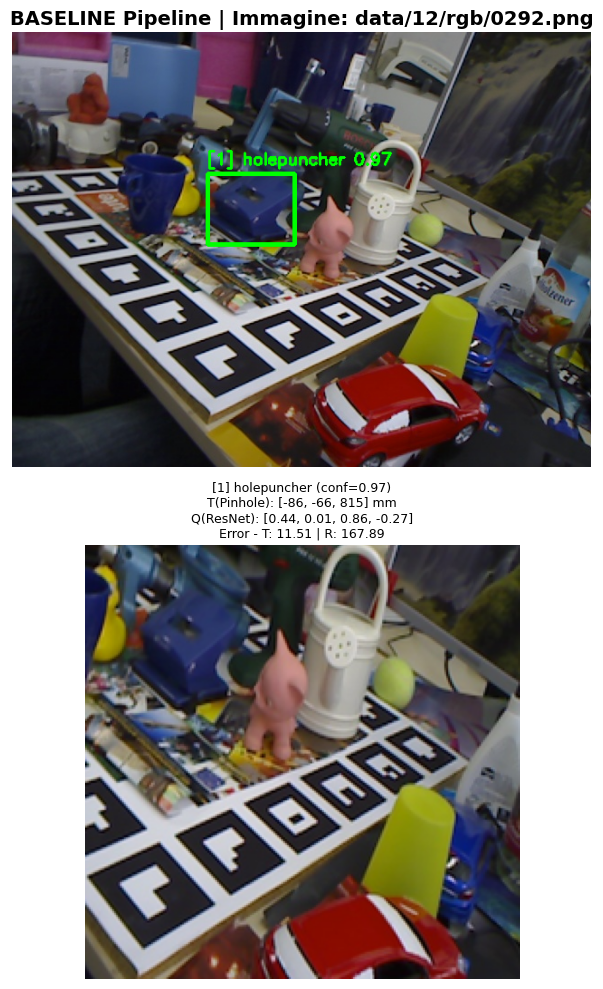

✅ BASELINE PIPELINE COMPLETATA!
   Oggetti rilevati: 1
   Translation: Pinhole Camera Model (geometrico)
   Rotation: ResNet50 (learned)

🎲 Esegui di nuovo per testare altra immagine!


In [21]:
# ====== PIPELINE BASELINE: YOLO → PINHOLE → RESNET ======

if yolo_detector is None or model_baseline is None:
    print("❌ Errore: I modelli non sono caricati!")
    print(f"   YOLO Detector: {'✅' if yolo_detector is not None else '❌'}")
    print(f"   PoseEstimatorBaseline: {'✅' if model_baseline is not None else '❌'}")
else:
    print("=" * 60)
    print("🔗 PIPELINE BASELINE: YOLO + Pinhole + ResNet Rotation")
    print("=" * 60)
    
    print(f"\n📋 Configurazione Pipeline:")
    print(f"   YOLO: {yolo_weights.name}")
    print(f"   PoseEstimatorBaseline: {'Trained' if checkpoint_path.exists() else 'Pretrained only'}")
    print(f"   Device: {Config.DEVICE}\n")
    
    # ✅ Selezione immagine casuale
    print("🎲 Selezione immagine casuale dal dataset...\n")
    
    data_root = Config.LINEMOD_ROOT / 'data'
    available_images = []
    
    for obj_folder in sorted(data_root.iterdir()):
        if obj_folder.is_dir() and obj_folder.name.isdigit():
            rgb_folder = obj_folder / 'rgb'
            if rgb_folder.exists():
                images_in_folder = list(rgb_folder.glob('*.png'))
                available_images.extend(images_in_folder)
    
    if not available_images:
        print("❌ Nessuna immagine trovata nel dataset")
    else:
        # Seleziona immagine casuale
        test_img_path = random.choice(available_images)
        test_image_RGB = np.array(Image.open(test_img_path).convert('RGB'))
        test_image_BGR = test_image_RGB[..., ::-1]
        
        obj_id = test_img_path.parent.parent.name
        img_name = test_img_path.name
        img_id = int(img_name.split('.')[0])
        
        print(f"📷 Immagine selezionata:")
        print(f"   Path: data/{obj_id}/rgb/{img_name}")
        print(f"   Size: {Config.YOLO_IMG_SIZE}")
        print(f"   Image ID: {img_id}\n")
        
        # Carica ground truth
        gt_path = data_root / obj_id / 'gt.yml'
        has_gt = False
        
        if gt_path.exists():
            with open(gt_path, 'r') as f:
                gt_data = yaml.safe_load(f)
            
            if img_id in gt_data and len(gt_data[img_id]) > 0:
                gt_pose = gt_data[img_id][0]
                gt_R = np.array(gt_pose['cam_R_m2c']).reshape(3, 3)
                gt_t = np.array(gt_pose['cam_t_m2c']).flatten()
                
                gt_quat = Rotation.from_matrix(gt_R).as_quat()
                gt_quat = np.array([gt_quat[3], gt_quat[0], gt_quat[1], gt_quat[2]])
                
                print(f"✅ Ground truth caricato:")
                print(f"   Translation: [{gt_t[0]:.1f}, {gt_t[1]:.1f}, {gt_t[2]:.1f}] mm")
                print(f"   Quaternion: [{gt_quat[0]:.3f}, {gt_quat[1]:.3f}, {gt_quat[2]:.3f}, {gt_quat[3]:.3f}]\n")
                has_gt = True
        
        # ✅ Step 1: YOLO detection
        print("🔍 Step 1: YOLO Detection...")
        detections = yolo_detector.detect_objects(test_image_BGR, conf_threshold=0.3)
        print(f"   Rilevati {len(detections)} oggetti\n")
        
        if len(detections) == 0:
            print("❌ Nessun oggetto rilevato.")
            print("   💡 Esegui di nuovo per testare un'altra immagine")
        else:
            # ✅ Step 2: Per ogni detection, calcola pose con Baseline
            print("✂️  Step 2: Pinhole Translation + ResNet Rotation...\n")
            
            pose_transforms = get_pose_transforms(train=False)
            results = []
            
            # Carica camera intrinsics (uguale per tutte le immagini dello stesso oggetto)
            camera_intrinsics = load_camera_intrinsics(gt_path)
            print(f"📷 Camera Intrinsics:")
            print(f"   fx={camera_intrinsics['fx']:.2f}, fy={camera_intrinsics['fy']:.2f}")
            print(f"   cx={camera_intrinsics['cx']:.2f}, cy={camera_intrinsics['cy']:.2f}\n")
            
            for idx, det in enumerate(detections):
                bbox = det['bbox']
                obj_name = det['class_name']
                conf = det['confidence']
                
                print(f"   [{idx+1}/{len(detections)}] {obj_name} (conf={conf:.2f})")
                print(f"         Bbox: [{int(bbox[0])}, {int(bbox[1])}, {int(bbox[2])}, {int(bbox[3])}]")
                
                # ✅ BASELINE: Calcola translation con Pinhole Camera Model
                depth_path = data_root / obj_id / 'depth' / img_name
                
                try:
                    pred_trans_mm = compute_translation_pinhole(
                        bbox, depth_path, camera_intrinsics
                    )
                    print(f"         ✅ Pinhole Translation: [{pred_trans_mm[0]:.1f}, {pred_trans_mm[1]:.1f}, {pred_trans_mm[2]:.1f}] mm")
                except Exception as e:
                    print(f"         ❌ Pinhole failed: {e}")
                    continue
                
                # ✅ BASELINE: Crop e predici rotation con ResNet
                cropped = crop_image_from_bbox(
                    test_image_RGB,
                    bbox,
                    margin=Config.POSE_CROP_MARGIN,
                    output_size=(Config.POSE_IMAGE_SIZE, Config.POSE_IMAGE_SIZE)
                )
                
                cropped_tensor = pose_transforms(cropped)
                cropped_tensor = cropped_tensor.unsqueeze(0).to(Config.DEVICE)
                
                with torch.no_grad():
                    pred_quat = model_baseline(cropped_tensor)
                
                pred_quat = pred_quat[0].cpu().numpy()
                
                print(f"         ✅ ResNet Quaternion: [{pred_quat[0]:.3f}, {pred_quat[1]:.3f}, {pred_quat[2]:.3f}, {pred_quat[3]:.3f}]\n")
                
                results.append({
                    'bbox': bbox,
                    'class_name': obj_name,
                    'confidence': conf,
                    'quaternion': pred_quat,
                    'translation': pred_trans_mm,
                    'cropped': np.array(cropped)
                })
            
            # ✅ Step 3: Confronto con Ground Truth
            print("📊 Step 3: Confronto con Ground Truth...\n")
            
            if has_gt and len(results) > 0:
                comparison_data = []
                
                for idx, res in enumerate(results):
                    pred_quat = res['quaternion']
                    pred_trans = res['translation']
                    
                    # Errore translation
                    trans_error = np.linalg.norm(pred_trans - gt_t)
                    
                    # Errore rotation
                    pred_R = Rotation.from_quat([pred_quat[1], pred_quat[2], pred_quat[3], pred_quat[0]]).as_matrix()
                    R_error = pred_R.T @ gt_R
                    trace = np.trace(R_error)
                    rot_error_rad = np.arccos(np.clip((trace - 1) / 2, -1, 1))
                    rot_error_deg = np.degrees(rot_error_rad)
                    
                    comparison_data.append({
                        'Oggetto': f"[{idx+1}] {res['class_name']}",
                        'Method': 'Baseline',
                        'Confidence': f"{res['confidence']:.3f}",
                        'Pred T (mm)': f"[{pred_trans[0]:.1f}, {pred_trans[1]:.1f}, {pred_trans[2]:.1f}]",
                        'GT T (mm)': f"[{gt_t[0]:.1f}, {gt_t[1]:.1f}, {gt_t[2]:.1f}]",
                        'Trans Error (mm)': f"{trans_error:.2f}",
                        'Pred Q (w,x,y,z)': f"[{pred_quat[0]:.3f}, {pred_quat[1]:.3f}, {pred_quat[2]:.3f}, {pred_quat[3]:.3f}]",
                        'GT Q (w,x,y,z)': f"[{gt_quat[0]:.3f}, {gt_quat[1]:.3f}, {gt_quat[2]:.3f}, {gt_quat[3]:.3f}]",
                        'Rot Error (deg)': f"{rot_error_deg:.2f}"
                    })
                
                df_comparison = pd.DataFrame(comparison_data)
                
                print("📋 TABELLA RISULTATI: Baseline (Pinhole + ResNet)")
                print("=" * 150)
                pd.set_option('display.max_columns', None)
                pd.set_option('display.width', None)
                pd.set_option('display.max_colwidth', None)
                print(df_comparison.to_string(index=False))
                print("=" * 150)
                
                # Metriche aggregate
                trans_errors = [float(d['Trans Error (mm)']) for d in comparison_data]
                rot_errors = [float(d['Rot Error (deg)']) for d in comparison_data]
                
                print(f"\n📏 Metriche Aggregate (Baseline):")
                print(f"   Translation Error - Media: {np.mean(trans_errors):.2f} mm")
                print(f"   Rotation Error    - Media: {np.mean(rot_errors):.2f}°\n")
            
            # ✅ Step 4: Visualizzazione
            print(f"🎨 Step 4: Visualizzazione risultati...\n")
            
            n_detections = len(results)
            n_cols = min(3, n_detections)
            n_rows = (n_detections + n_cols - 1) // n_cols
            
            fig = plt.figure(figsize=(15, 5 * (n_rows + 1)))
            
            # Immagine originale con bbox
            img_with_bbox = test_image_RGB.copy()
            try:
                import cv2
                colors_bgr = [(0, 255, 0), (255, 0, 0), (0, 0, 255)]
                for idx, res in enumerate(results):
                    x1, y1, x2, y2 = res['bbox']
                    color = colors_bgr[idx % len(colors_bgr)]
                    cv2.rectangle(img_with_bbox, (int(x1), int(y1)), (int(x2), int(y2)), color, 3)
                    label = f"[{idx+1}] {res['class_name']} {res['confidence']:.2f}"
                    cv2.putText(img_with_bbox, label, (int(x1), int(y1) - 10),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
            except ImportError:
                pass
            
            ax_orig = plt.subplot2grid((n_rows + 1, n_cols), (0, 0), colspan=n_cols)
            ax_orig.imshow(img_with_bbox)
            ax_orig.set_title(f"BASELINE Pipeline | Immagine: data/{obj_id}/rgb/{img_name}", 
                            fontsize=14, fontweight='bold')
            ax_orig.axis('off')
            
            # Crops con pose
            for idx, res in enumerate(results):
                row = (idx // n_cols) + 1
                col = idx % n_cols
                ax = plt.subplot2grid((n_rows + 1, n_cols), (row, col))
                ax.imshow(res['cropped'])
                
                if has_gt:
                    trans_err = comparison_data[idx]['Trans Error (mm)']
                    rot_err = comparison_data[idx]['Rot Error (deg)']
                    title = (
                        f"[{idx+1}] {res['class_name']} (conf={res['confidence']:.2f})\n"
                        f"T(Pinhole): [{res['translation'][0]:.0f}, {res['translation'][1]:.0f}, {res['translation'][2]:.0f}] mm\n"
                        f"Q(ResNet): [{res['quaternion'][0]:.2f}, {res['quaternion'][1]:.2f}, "
                        f"{res['quaternion'][2]:.2f}, {res['quaternion'][3]:.2f}]\n"
                        f"Error - T: {trans_err} | R: {rot_err}"
                    )
                else:
                    title = (
                        f"[{idx+1}] {res['class_name']} (conf={res['confidence']:.2f})\n"
                        f"T: [{res['translation'][0]:.0f}, {res['translation'][1]:.0f}, {res['translation'][2]:.0f}] mm\n"
                        f"Q: [{res['quaternion'][0]:.2f}, {res['quaternion'][1]:.2f}, "
                        f"{res['quaternion'][2]:.2f}, {res['quaternion'][3]:.2f}]"
                    )
                ax.set_title(title, fontsize=9)
                ax.axis('off')
            
            plt.tight_layout()
            plt.show()
            
            print(f"=" * 60)
            print(f"✅ BASELINE PIPELINE COMPLETATA!")
            print(f"=" * 60)
            print(f"   Oggetti rilevati: {n_detections}")
            print(f"   Translation: Pinhole Camera Model (geometrico)")
            print(f"   Rotation: ResNet50 (learned)")
            print(f"\n🎲 Esegui di nuovo per testare altra immagine!")
            print(f"=" * 60)

## 4. Test Statistico su Multiple Immagini

Test del baseline su 20 immagini casuali per valutare performance medie.

🔬 TEST STATISTICO BASELINE (Multiple Immagini)

🎲 Testing su 20 immagini casuali...



Processing: 100%|██████████| 20/20 [00:22<00:00,  1.10s/it]


📊 STATISTICHE BASELINE
   Immagini testate: 20
   Predizioni riuscite: 20
   Detection fallite: 0
   Pinhole falliti: 0
   Success rate: 100.0%

📏 TRANSLATION ERROR (Pinhole Camera Model):
   Media:   50.25 mm
   Mediana: 22.50 mm
   Min:     1.85 mm
   Max:     303.44 mm

🔄 ROTATION ERROR (ResNet Baseline):
   Media:   118.59°
   Mediana: 123.14°
   Min:     30.41°
   Max:     174.69°

📈 DISTRIBUZIONE ERRORI:
   Translation < 20mm:  50.0%
   Translation < 50mm:  80.0%
   Rotation < 30°:      0.0%
   Rotation < 60°:      5.0%


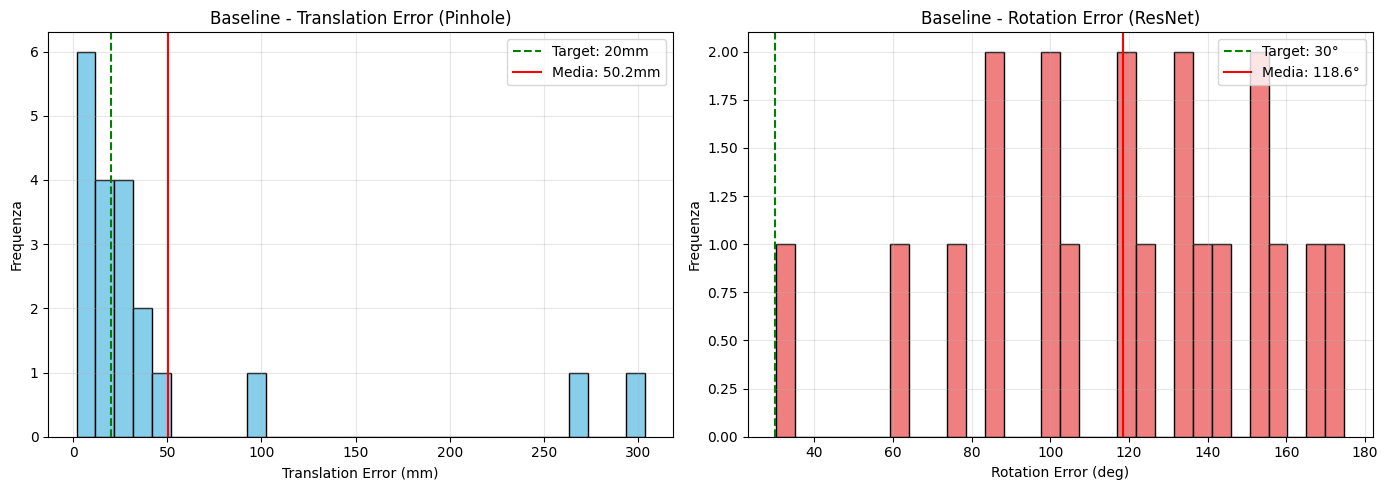


🎯 VALUTAZIONE BASELINE
   ⚠️ SUFFICIENTE - Necessita training baseline

💡 Note:
   - Translation (Pinhole) è geometrico → Accuratezza dipende da depth map
   - Rotation (ResNet) è learned → Accuratezza dipende da training
   - ⚠️  Modello non trained! Performance rotation può migliorare con training


In [22]:
# ====== TEST STATISTICO BASELINE ======
print("=" * 60)
print("🔬 TEST STATISTICO BASELINE (Multiple Immagini)")
print("=" * 60)

if yolo_detector is None or model_baseline is None:
    print("❌ Modelli non caricati!")
else:
    NUM_TEST_IMAGES = 20
    
    all_trans_errors = []
    all_rot_errors = []
    successful_predictions = 0
    failed_detections = 0
    failed_pinhole = 0
    
    print(f"\n🎲 Testing su {NUM_TEST_IMAGES} immagini casuali...\n")
    
    pose_transforms = get_pose_transforms(train=False)
    test_images = random.sample(available_images, min(NUM_TEST_IMAGES, len(available_images)))
    
    for test_img_path in tqdm(test_images, desc="Processing"):
        test_image_RGB = np.array(Image.open(test_img_path).convert('RGB'))
        test_image_BGR = test_image_RGB[..., ::-1]
        obj_id = test_img_path.parent.parent.name
        img_name = test_img_path.name
        img_id = int(img_name.split('.')[0])
        
        # Carica GT
        gt_path = data_root / obj_id / 'gt.yml'
        if not gt_path.exists():
            continue
        
        with open(gt_path, 'r') as f:
            gt_data = yaml.safe_load(f)
        
        if img_id not in gt_data or len(gt_data[img_id]) == 0:
            continue
        
        gt_pose = gt_data[img_id][0]
        gt_R = np.array(gt_pose['cam_R_m2c']).reshape(3, 3)
        gt_t = np.array(gt_pose['cam_t_m2c']).flatten()
        
        # YOLO detection
        detections = yolo_detector.detect_objects(test_image_BGR, conf_threshold=0.3)
        
        if len(detections) == 0:
            failed_detections += 1
            continue
        
        det = detections[0]
        bbox = det['bbox']
        
        # Pinhole translation
        depth_path = data_root / obj_id / 'depth' / img_name
        camera_intrinsics = load_camera_intrinsics(gt_path)
        
        try:
            pred_trans = compute_translation_pinhole(bbox, depth_path, camera_intrinsics)
        except Exception:
            failed_pinhole += 1
            continue
        
        # ResNet rotation
        cropped = crop_image_from_bbox(
            test_image_RGB, bbox,
            margin=Config.POSE_CROP_MARGIN,
            output_size=(Config.POSE_IMAGE_SIZE, Config.POSE_IMAGE_SIZE)
        )
        
        cropped_tensor = pose_transforms(cropped).unsqueeze(0).to(Config.DEVICE)
        
        with torch.no_grad():
            pred_quat = model_baseline(cropped_tensor)
        
        pred_quat = pred_quat[0].cpu().numpy()
        
        # Calcola errori
        trans_error = np.linalg.norm(pred_trans - gt_t)
        
        pred_R = Rotation.from_quat([pred_quat[1], pred_quat[2], pred_quat[3], pred_quat[0]]).as_matrix()
        R_error = pred_R.T @ gt_R
        trace = np.trace(R_error)
        rot_error_rad = np.arccos(np.clip((trace - 1) / 2, -1, 1))
        rot_error_deg = np.degrees(rot_error_rad)
        
        all_trans_errors.append(trans_error)
        all_rot_errors.append(rot_error_deg)
        successful_predictions += 1
    
    # Statistiche
    print("\n" + "=" * 60)
    print("📊 STATISTICHE BASELINE")
    print("=" * 60)
    print(f"   Immagini testate: {NUM_TEST_IMAGES}")
    print(f"   Predizioni riuscite: {successful_predictions}")
    print(f"   Detection fallite: {failed_detections}")
    print(f"   Pinhole falliti: {failed_pinhole}")
    print(f"   Success rate: {100 * successful_predictions / NUM_TEST_IMAGES:.1f}%")
    
    if len(all_trans_errors) > 0:
        print(f"\n📏 TRANSLATION ERROR (Pinhole Camera Model):")
        print(f"   Media:   {np.mean(all_trans_errors):.2f} mm")
        print(f"   Mediana: {np.median(all_trans_errors):.2f} mm")
        print(f"   Min:     {np.min(all_trans_errors):.2f} mm")
        print(f"   Max:     {np.max(all_trans_errors):.2f} mm")
        
        print(f"\n🔄 ROTATION ERROR (ResNet Baseline):")
        print(f"   Media:   {np.mean(all_rot_errors):.2f}°")
        print(f"   Mediana: {np.median(all_rot_errors):.2f}°")
        print(f"   Min:     {np.min(all_rot_errors):.2f}°")
        print(f"   Max:     {np.max(all_rot_errors):.2f}°")
        
        # Distribuzione
        trans_under_20 = sum(e < 20 for e in all_trans_errors)
        trans_under_50 = sum(e < 50 for e in all_trans_errors)
        rot_under_30 = sum(e < 30 for e in all_rot_errors)
        rot_under_60 = sum(e < 60 for e in all_rot_errors)
        
        print(f"\n📈 DISTRIBUZIONE ERRORI:")
        print(f"   Translation < 20mm:  {100 * trans_under_20 / len(all_trans_errors):.1f}%")
        print(f"   Translation < 50mm:  {100 * trans_under_50 / len(all_trans_errors):.1f}%")
        print(f"   Rotation < 30°:      {100 * rot_under_30 / len(all_rot_errors):.1f}%")
        print(f"   Rotation < 60°:      {100 * rot_under_60 / len(all_rot_errors):.1f}%")
        
        # Grafici
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        axes[0].hist(all_trans_errors, bins=30, color='skyblue', edgecolor='black')
        axes[0].axvline(20, color='green', linestyle='--', label='Target: 20mm')
        axes[0].axvline(np.mean(all_trans_errors), color='red', linestyle='-', 
                       label=f'Media: {np.mean(all_trans_errors):.1f}mm')
        axes[0].set_xlabel('Translation Error (mm)')
        axes[0].set_ylabel('Frequenza')
        axes[0].set_title('Baseline - Translation Error (Pinhole)')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        axes[1].hist(all_rot_errors, bins=30, color='lightcoral', edgecolor='black')
        axes[1].axvline(30, color='green', linestyle='--', label='Target: 30°')
        axes[1].axvline(np.mean(all_rot_errors), color='red', linestyle='-', 
                       label=f'Media: {np.mean(all_rot_errors):.1f}°')
        axes[1].set_xlabel('Rotation Error (deg)')
        axes[1].set_ylabel('Frequenza')
        axes[1].set_title('Baseline - Rotation Error (ResNet)')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Valutazione
        print("\n" + "=" * 60)
        print("🎯 VALUTAZIONE BASELINE")
        print("=" * 60)
        
        avg_trans = np.mean(all_trans_errors)
        avg_rot = np.mean(all_rot_errors)
        
        if avg_trans < 20 and avg_rot < 30:
            verdict = "✅ OTTIMO - Baseline molto accurato!"
        elif avg_trans < 50 and avg_rot < 60:
            verdict = "⚠️ BUONO - Baseline accettabile"
        else:
            verdict = "⚠️ SUFFICIENTE - Necessita training baseline"
        
        print(f"   {verdict}")
        print(f"\n💡 Note:")
        print(f"   - Translation (Pinhole) è geometrico → Accuratezza dipende da depth map")
        print(f"   - Rotation (ResNet) è learned → Accuratezza dipende da training")
        if not checkpoint_path.exists():
            print(f"   - ⚠️  Modello non trained! Performance rotation può migliorare con training")
    
    print("=" * 60)